# Attempted Simplification of Existing Mountain Car [Example](https://reactivebayes.github.io/RxInfer.jl/stable/examples/advanced_examples/Active%20Inference%20Mountain%20car/#examples-active-inference-mountain-car) 

In what follows, I have attempted to re-create the existing Mountain Car example from the set of "advanced" examples found in the RxInfer documentation. The specific Mountain Car example can be found [here](https://reactivebayes.github.io/RxInfer.jl/stable/examples/advanced_examples/Active%20Inference%20Mountain%20car/#examples-active-inference-mountain-car). 

My motivation with this "re-implementation" of the Mountain Car example is twofld. First, the existing implementation is perhaps a little "bloated". My aesthetic sense is that it would be nice to have a simpler instantiation of the same example. Second, I am interested in integrating the Mountain Car agent, defined via RxInfer, with the Mountain Car environment defined by [RxEnvironments](https://biaslab.github.io/RxEnvironments.jl/stable/lib/example_mountaincar/#lib-mountain-car). Regarding this latter end, it is not all that obvious how to "marry up" the existing RxInfer Mountain Car agent witht the new RxEnvironments environment specification, especially in light of the "imperative-like" specification of the exsiting implementation's 6 methods for control flow. 

My own approach has also ben twofold. First, I have taken the agent/environment specification of the agent and the environment, directly from the [RxEnvironments](https://biaslab.github.io/RxEnvironments.jl/stable/lib/example_mountaincar/#lib-mountain-car) example. This seemed like a natural choice, since I want to integrate this with RxEnvironments anyway. Secondly, I have tried model the agent's internal structure and the subequent inference process after the existing [drone navigation example](https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main). 

The implementation of the RxInfer drone navigation example is much simpler than that of the existing Mountain Car example in RxInfer. It therefore seemed to be another natural choice of agent-specification for a "simplified" Mountain Car agent. Specifically, the approach emboied in the [drone navigation example](https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main) example seems - to me - to offer a potential standardisation of the agent-specification procedure in RxInfer. This is due to its use of the following very general functions:

1. ```state_transition```, which specifies our assumptions about how the agent's internal states evolve with time. 
2. The agent's probabilistic model function (by means of the ```@model``` macro). 
3. ```move_to_target```, which handles the "main loop" of the inference procedure. 

I have attempted to run this simplified Mountain Car RxInfer agent, only to be met with several cryptic errors. I'm sure they are only "cryptic" to me and not in any unqualified sense. 

In [1]:
using Pkg; Pkg.activate("."); Pkg.instantiate()

  Activating new project at `~/Desktop/Active_Inference_Institute/RxInfer_Group/Simplified_Mountain_Car`
  No Changes to `~/Desktop/Active_Inference_Institute/RxInfer_Group/Simplified_Mountain_Car/Project.toml`
  No Changes to `~/Desktop/Active_Inference_Institute/RxInfer_Group/Simplified_Mountain_Car/Manifest.toml`


In [2]:
import HypergeometricFunctions: _₂F₁
using RxInfer
using Plots
using Distributions
using ForwardDiff
using DifferentialEquations
using LinearAlgebra

## Setup

The following defines a generic landscape function to use as the "mountain". Note that the environment will also work with other (differentiable) landscape functions.

In [3]:
function landscape(x)
    if x < 0
        h = x^2 + x
    else
        h =
            x * _₂F₁(0.5, 0.5, 1.5, -5 * x^2) +
            x^3 * _₂F₁(1.5, 1.5, 2.5, -5 * x^2) / 3 +
            x^5 / 80
    end
    return 0.05 * h
end

landscape (generic function with 1 method)

### Visualising the Landscape Function:

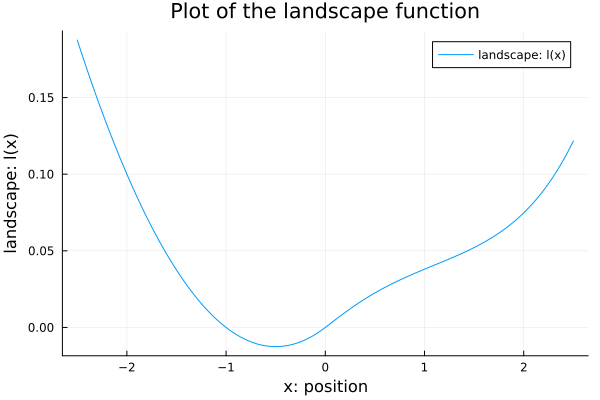

In [4]:
# Create the domain
x_values = -2.5:0.01:2.5

# Evaluate the range of the function
y_values = landscape.(x_values)

# Plot the results
plot(
    x_values, 
    y_values, 
    label = "landscape: l(x)", 
    xlabel = "x: position", 
    ylabel = "landscape: l(x)", 
    title = "Plot of the landscape function"
)

## Agent/Environment Structures

Everything from here until the next section is taken directly from the [existing Mountain Car example](https://biaslab.github.io/RxEnvironments.jl/stable/lib/example_mountaincar/#lib-mountain-car), in the RxEnvironments documentation.

Below, we create a structure in which we are going to store the precomputed trajectory of the mountain car:

In [5]:
mutable struct MountainCarTrajectory{T<:Real}
    time_left::T
    trajectory::Any
    T::T
end

In [6]:
# Convenient getters and setters

time_left(
    trajectory::MountainCarTrajectory
) = trajectory.time_left

current_time(
    trajectory::MountainCarTrajectory
) = total_time(trajectory) - time_left(trajectory)

total_time(
    trajectory::MountainCarTrajectory
) = trajectory.T

Base.getindex(
    trajectory::MountainCarTrajectory, 
    index
) = trajectory.trajectory(index)


set_time_left!(
    trajectory::MountainCarTrajectory, 
    time_left) = trajectory.time_left = time_left

reduce_time_left!(
    trajectory::MountainCarTrajectory, elapsed_time
) = set_time_left!(trajectory, time_left(trajectory) - elapsed_time)

reduce_time_left! (generic function with 1 method)

This trajectory is wrapped in the state of a Mountain Car, which contains all variables of the mountain car that are subject to change, such as position and velocity.

In [7]:
mutable struct MountainCarState{T<:Real}
    position::T
    velocity::T
    throttle::T
    trajectory::MountainCarTrajectory{T}
end

In [8]:
# Convenient getters and setters
position(
    state::MountainCarState
) = state.position

velocity(
    state::MountainCarState
) = state.velocity

throttle(
    state::MountainCarState
) = state.throttle

observable_state(
    state::MountainCarState
) = [position(state), velocity(state)]

set_position!(
    state::MountainCarState, position::Real
) = state.position = position

set_velocity!(
    state::MountainCarState, velocity::Real
) = state.velocity = velocity

set_throttle!(
    state::MountainCarState, throttle::Real
) = state.throttle = throttle

set_trajectory!(
    state::MountainCarState, trajectory
) = state.trajectory = trajectory

trajectory(
    state::MountainCarState
) = state.trajectory

trajectory (generic function with 1 method)

In [9]:
# This is a convenient constructor that creates an empty trajectory 
# that will immediately be replaced.
MountainCarState(
    position::Real, velocity::Real, throttle::Real
) = MountainCarState(
    position,
    velocity,
    throttle,
    MountainCarTrajectory(0.0, [], 0.0),
)

MountainCarState

The actual Mountain Car struct will contain the state of the mountain car, as well as constants such as the engine power and friction coefficient:

In [10]:
struct MountainCarAgent{T<:Real}
    state::MountainCarState{T}
    engine_power::T
    friction_coefficient::T
    mass::T
    target::T
end

In [11]:
MountainCarAgent(
    position::Real,
    engine_power::Real,
    friction_coefficient::Real,
    mass::Real,
    target::Real,
) = MountainCarAgent(
    MountainCarState(position, 0.0, 0.0),
    engine_power,
    friction_coefficient,
    mass,
    target,
)

MountainCarAgent

In [12]:
# Convenient getters and setters
state(
    car::MountainCarAgent
) = car.state

position(
    car::MountainCarAgent
) = position(state(car))
    
velocity(
    car::MountainCarAgent
) = velocity(state(car))

throttle(
    car::MountainCarAgent
) = throttle(state(car))

mass(
    car::MountainCarAgent
) = car.mass

observable_state(
    car::MountainCarAgent
) = observable_state(state(car))

get_properties(
    car::MountainCarAgent
) = (car.mass, car.engine_power, car.friction_coefficient, car.target)
    

set_position!(
    car::MountainCarAgent, position::Real
) = set_position!(state(car), position)

set_velocity!(
    car::MountainCarAgent, velocity::Real
) = set_velocity!(state(car), velocity)

set_throttle!(
    car::MountainCarAgent, throttle::Real
) = set_throttle!(state(car), throttle)

engine_power(
    car::MountainCarAgent
) = car.engine_power

friction_coefficient(
    car::MountainCarAgent
) = car.friction_coefficient

set_trajectory!(
    car::MountainCarAgent, trajectory
) = set_trajectory!(state(car), trajectory)

trajectory(
    car::MountainCarAgent
) = trajectory(state(car))
    

trajectory (generic function with 2 methods)

Now we are in a shape where we can define the actual environment, which will contain a landscape function and a Mountain Car:

In [13]:
struct MountainCarEnvironment
    agent::MountainCarAgent
    landscape::Any
end

In [14]:
MountainCarEnvironment(
    landscape
) = MountainCarEnvironment([], landscape)

MountainCarEnvironment

# The Agent's Internal Structure

In [15]:
"""
state_transition(car::MountainCarAgent, dt::Float64)

This function computes the next state of the mountain car given the 
current state, the actions, the car properties, and the environment properties.

TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone
"""
function state_transition(car::MountainCarAgent, environment::MountainCarEnvironment, dt::Float64)
    # Extract car properties
    m, engine_power, friction_coefficient, target = get_properties(car)
    
    # Extract state properties
    pos = position(car)
    vel = velocity(car)
    throttle_input = throttle(car)
    
    # Compute the slope of the landscape at the current position
    slope = ForwardDiff.derivative(environment.landscape, pos)
    
    # Compute forces
    engine_force = engine_power * throttle_input
    gravity_force = -m * 9.81 # * slope # wrong
    friction_force = -friction_coefficient * vel
    
    # Total force
    total_force = engine_force + gravity_force + friction_force
    
    # Compute acceleration
    acceleration = total_force / m
    
    # Update velocity and position
    new_vel = vel + acceleration * dt
    new_pos = pos + vel * dt + 0.5 * acceleration * dt^2
    
    # Update state
    set_velocity!(state(car), new_vel)
    set_position!(state(car), new_pos)
    
#     return car
    
    return [new_pos, new_vel]
end


state_transition

In [16]:
# This function specifies the mountain car agent's generative model.
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone

@model function mcar_model(
        car, environment, initial_state, goal, horizon, dt
    )

    # extract car properties
    m, engine_power, friction_coefficient, target = get_properties(car)

    # initial state prior
    s[1] ~ MvNormal(mean = initial_state, covariance = 1e-5 * I(2))  # position and velocity

    for i in 1:horizon

        # prior on throttle (actions)
        u[i] ~ Normal(0, 1)  # assuming throttle is scalar and normalized

        # state transition
        next_state = state_transition(car, environment, dt)
#         s[i + 1] ~ MvNormal(mean = [next_state.position, next_state.velocity], covariance = 1e-10 * I(2))
        s[i + 1] ~ MvNormal(mean = next_state, covariance = 1e-10 * I(2))
    end

    s[end] ~ MvNormal(mean = goal, covariance = 1e-5 * I(2))  # goal for position and velocity

end

## Probabilistic inference

In [17]:
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone

@meta function mcar_meta()
    # approximate the state transition function using the Unscented transform
    state_transition() -> Unscented()
end

mcar_meta (generic function with 1 method)

In [18]:
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone

function move_to_target(
        car::MountainCarAgent, 
        env::MountainCarEnvironment, 
        start::MountainCarState, 
        target, 
        horizon,
        dt
    )

    results = infer(
        
        model = mcar_model(
            car = car,
            environment = env,
            horizon = horizon,
            dt = dt
        ),
        
        data  = (
            initial_state = [position(start), velocity(start)],
#             goal = [target[1], target[2]]
            goal = target
        ),

        meta  = mcar_meta(),

        returnvars = (
            s = KeepLast(), 
            u = KeepLast()
        )
    )

    return results

end

move_to_target (generic function with 1 method)

In [19]:
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone

time_horizon = 100.0

start = MountainCarState(
    -0.5, # T
    0.0, # T
    0.0, # T
    MountainCarTrajectory(
        time_horizon,
        [],
        time_horizon
    )
)

# target = [0.5, 0.0] 
target = 0.5

mcar_agent = MountainCarAgent(
    start, # MountainCarState{T}
    0.5, # T
    0.1, # T
    0.2, # T
    target # T
)

mcar_env = MountainCarEnvironment(
    mcar_agent,
    landscape
)

MountainCarEnvironment(MountainCarAgent{Float64}(MountainCarState{Float64}(-0.5, 0.0, 0.0, MountainCarTrajectory{Float64}(100.0, Any[], 100.0)), 0.5, 0.1, 0.2, 0.5), landscape)

In [20]:
# TAKEN FROM/INSPIRED BY THE EXISTING DRONE NAVIGATION EXAMPLE: 
# https://github.com/ReactiveBayes/RxInferExamples.jl/tree/main/drone

results = move_to_target(
    mcar_agent, 
    mcar_env, 
    start, 
    target, 
    time_horizon, 
    0.05
)

LoadError: Backend GraphPPL.DefaultBackend() must implement a method for `NodeType` for `UniformScaling{Bool}(true)`.